<a href="https://colab.research.google.com/github/DarwinFer/ExampleEDO/blob/main/E1OsciladorArminioPINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Ejemplo 1:  Agragar la física al modelo

En adelante presentamos un ejemplo  que ilustra la diferencia de el uso de la física en la solición o aproximación de EDO's.


> Supongamos que estamos intentando modelar el  **oscilador armónico amortiguado**

<img src="https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/oscillator.gif?raw=1" width="500">

(*Animación tomada  de https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/tree/main*)



Es decir, nos interesa modelar el desplazamiento de la masa en un resorte (caja verde) a lo largo del tiempo $t$.

Este es un problema estandar en física, donde el desplazamiento, $u(t)$, del oscilador como función del tiempo puede describirse mediante la siguiente ecuación diferencial:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~ \qquad (1)
$$


donde $m$ es la masa del oscilador, $\mu$ es el coeficiente de fricción y $k$ es la constante del resorte.

Nos enfocaremos en resolver el problema en el **estado subamortiguado**, es decir, cuando la oscilación se amortigua lentamente debido a la fricción (como se muestra en la animación de arriba).

Desde el punto de vista matemático, esto ocurre cuando:

$$
\delta < \omega_0~,~~~~~\mathrm{donde}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.   \qquad (2)
$$

Además, consideramos las siguientes condiciones iniciales del sistema:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

Para este caso particular, la solución exacta es conocida y está dada por:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{con}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

Para una descripción matemática más detallada del oscilador armónico, consulta esta publicación en el blog: https://beltoforion.de/en/harmonic_oscillator/

##Generando datos de entrenamiento

>   Datos para la simulación:

Dado que este es un problema  con solución exacta conocida,  podemos generar datos de entremaniento  para que nuestra una red neuornal aprendrenda, primero definimos la solución exacta y la evaluamos en ciertos $t_{
i} \in [0,T_{train}]$. Como resultado tendremos datos etiquetados de la forma ${t_{i}, u(x_{i})}$, por su puesto para  los parametros convenientes del caso subamortiguado. Primero como es habitual empezamos importando las librerias,  en  este caso usaremos PyTorch como libreria base para la implementación de las redes neuronales.




In [ ]:
#Importamos las librerias necesarias.
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

>En seguida,

In [ ]:
# ---- Solución exacta del oscilador armónico subamortiguado ----
def exact_solution(d, w0, t):
    """Solución analítica al problema del oscilador armónico subamortiguado"""
    # Parámetros a tensores PyTorch
    d_t = torch.tensor(d, dtype=torch.float32)
    w0_t = torch.tensor(w0, dtype=torch.float32)
    # Frecuencia amortiguada y fase inicial
    w = torch.sqrt(w0_t**2 - d_t**2)
    phi = torch.atan(-d_t / w)
    A = 1 / (2 * torch.cos(phi))
    # Solución exacta
    cos_term = torch.cos(phi + w * t)
    exp_term = torch.exp(-d_t * t)
    return exp_term * 2 * A * cos_term



In [ ]:

# ---- Parámetros del sistema ----
d = 2.0        # coeficiente de fricción
w0 = 20.0      # frecuencia natural (> d para estado subamortiguado)

# ---- Definir dominios de tiempo ----n# Dominio para PLOT completo
t_plot_max = 1.0
# Dominio para DATOS de entrenamiento (hasta t < t_plot_max)
t_train_max = 0.4    # solo hasta t = 3
num_points = 10      # número de puntos de entrenamiento

# Puntos de entrenamiento (hasta t_train_max)
t_train = torch.linspace(0, t_train_max, num_points).reshape(-1,1)
u_train = exact_solution(d, w0, t_train)


# Visualizar los datos generados
# plt.figure(figsize=(8, 6))
# plt.plot(t_experimental.detach().numpy(), u_experimental.detach().numpy(), 'o', label='Datos experimentales')
# plt.xlabel('Tiempo (t)')
# plt.ylabel('Desplazamiento (u)')
# plt.title('Datos de Entrenamiento para el Oscilador Armónico Subamortiguado')
# plt.legend()
# plt.grid(True)
# plt.show()


##Creando una red neuoronal  (NN)

>Siguiendo nuesto objetivo, creamos una red neuronal que aproxime la solución de  (2), mediante un rede neuronal la cual se entrena con los datos de entrenamiento previamente obtenidos. Aprovechando la capacidad de las redes neuronales como aproximadores universales  para aproximar directamente la solución de la ecuación diferencial, es decir,

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$
>Supongamos que deseamos usar el error cuadratico medio para entregar nuestra red neuronal usando unicamente nuestros datos de entrenamiento previamente ilustrados

In [ ]:

# ---- Modelo de red neuronal ----
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,1)
        )
    def forward(self, x):
        return self.net(x)

# Semilla y creación de modelo
torch.manual_seed(123)
model = SimpleNN()

# Función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Marcar para autograd
t_train.requires_grad_(True)

# ---- Entrenamiento ----
epochs = 5001
loss_history = []
for ep in range(1, epochs+1):
    pred = model(t_train)
    loss = criterion(pred, u_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if ep % 500 == 0:
        print(f"Epoch {ep}/{epochs}, Loss: {loss.item():.6f}")


Epoch 500/5001, Loss: 0.000371
Epoch 1000/5001, Loss: 0.000022
Epoch 1500/5001, Loss: 0.000005
Epoch 2000/5001, Loss: 0.000003
Epoch 2500/5001, Loss: 0.000001
Epoch 3000/5001, Loss: 0.000000
Epoch 3500/5001, Loss: 0.000000
Epoch 4000/5001, Loss: 0.000000
Epoch 4500/5001, Loss: 0.000000
Epoch 5000/5001, Loss: 0.000001


> Visualizar los resultados,

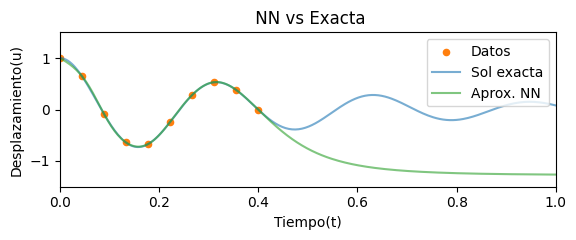

In [ ]:
# ---- Evaluación y visualización ----
# Puntos densos para graficar solución completa
t_plot = torch.linspace(0, t_plot_max, 300).reshape(-1,1)
u_exact = exact_solution(d, w0, t_plot)
u_pred = model(t_plot).detach()

plt.figure(figsize=(6,2.5))
# Datos entrenamiento
plt.scatter(t_train.detach().numpy(), u_train.detach().numpy(), color="tab:orange", s=20, label='Datos')
# Solución exacta
plt.plot(t_plot.detach().numpy(), u_exact.detach().numpy(),color="tab:blue", label='Sol exacta', alpha=0.6)
# Aproximación NN
plt.plot(t_plot.detach().numpy(), u_pred.detach().numpy(), color="tab:green",label='Aprox. NN', alpha=0.6)

plt.xlabel('Tiempo(t)')
plt.ylabel('Desplazamiento(u)')
plt.title(' NN vs Exacta')
plt.legend(loc='upper right')
#plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(0, t_plot_max)
plt.ylim(-1.5, 1.5)
plt.tight_layout()
# Guardar como PDF
plt.savefig("NNvsExacta.pdf", format="pdf")
plt.show()


Epoch 1000/5001, Loss: 0.000036


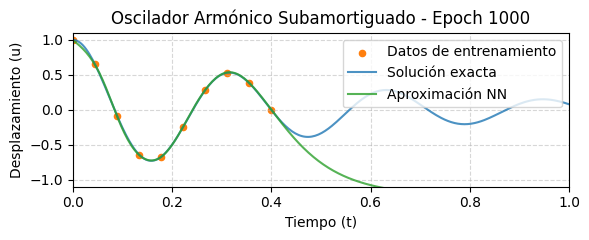

Epoch 2000/5001, Loss: 0.000000


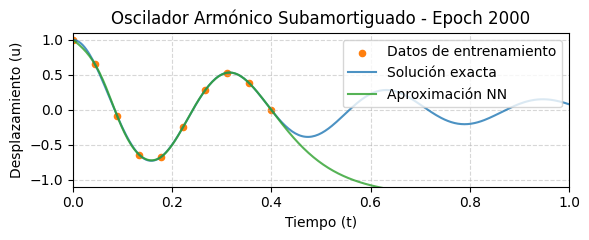

Epoch 3000/5001, Loss: 0.000000


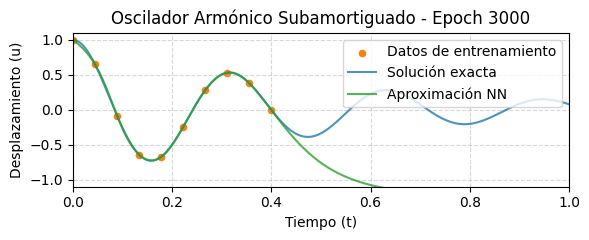

Epoch 4000/5001, Loss: 0.000000


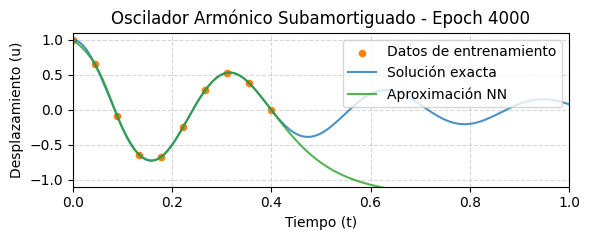

Epoch 5000/5001, Loss: 0.000000


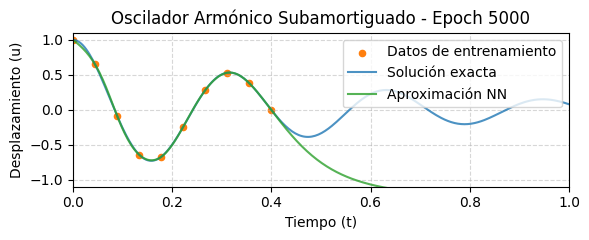

In [ ]:
# ---- Entrenamiento con visualización periódica ----
epochs = 5001
loss_history = []

for ep in range(1, epochs + 1):
    pred = model(t_train)
    loss = criterion(pred, u_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    # Mostrar avance cada 500 epochs
    if ep % 1000 == 0:
        print(f"Epoch {ep}/{epochs}, Loss: {loss.item():.6f}")

    # Gráfica cada 1000 epochs
    if ep % 1000 == 0:
        t_plot = torch.linspace(0, t_plot_max, 300).reshape(-1, 1)
        u_exact = exact_solution(d, w0, t_plot)
        u_pred = model(t_plot).detach()

        plt.figure(figsize=(6, 2.5))
        plt.scatter(t_train.detach().numpy(), u_train.detach().numpy(),
                    color="tab:orange", s=20, label='Datos de entrenamiento')
        plt.plot(t_plot.detach().numpy(), u_exact.detach().numpy(),
                 color="tab:blue", label='Solución exacta', alpha=0.8)
        plt.plot(t_plot.detach().numpy(), u_pred.detach().numpy(),
                 color="tab:green", label='Aproximación NN', alpha=0.8)

        plt.xlabel('Tiempo (t)')
        plt.ylabel('Desplazamiento (u)')
        plt.title(f'Oscilador Armónico Subamortiguado - Epoch {ep}')
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xlim(0, t_plot_max)
        plt.ylim(-1.1, 1.1)
        plt.tight_layout()
        plt.show()


##Enforque de redes neuronales informadas por las física

Estamos interesado en mirar el efecto de incoporar la física en el entrenamiento, es decir mirar la eficiencia de las PINNs, en contraste con una NN normal. En particular en este enfoque no necesitamos de  datos etiquetados para que nuestra red neuronal aprenda,  específicamente, nuestras entradas y son  la ecuación diferencial subyacente y las condiciones iniciales del sistema  y las salidas: una estimación de la solución, $u(t)$

#### Enfoque

Como se ha explicado la PINN se entrena para aproximar directamente la solución de la ecuación diferencial, es decir,

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

donde $\theta$ representa los parámetros libres de la PINN.

#### Función de pérdida

Para simular el sistema, la PINN se entrena con la siguiente función de pérdida:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

Para esta tarea, usamos  los mismos parametros $\delta$, $\omega_0=$  del enfoque anterior y tratamos de aprender la solución en el dominio $t \in [0,10]$.

#### Notas

Los dos primeros términos en la función de pérdida representan la **pérdida de frontera**, y buscan asegurar que la solución aprendida por la PINN respete las condiciones iniciales del sistema, a saber: $u(t=0)=1$ y $u'(t=0)=0$.

El segundo término en la función de pérdida se denomina **pérdida física**, y busca asegurar que la solución de la PINN cumpla la ecuación diferencial en un conjunto de puntos de entrenamiento $\{t_i\}$ muestreados en todo el dominio.

Los hiperparámetros $\lambda_1$ y $\lambda_2$ se utilizan para balancear los términos en la función de pérdida y asegurar la estabilidad durante el entrenamiento.

Se utiliza autodiferenciación (`torch.autograd`) para calcular los gradientes de la PINN respecto a su entrada, lo cual es necesario para evaluar la función de pérdida. ¡Esto es muy potente!

Para más detalles sobre `torch.autograd`, consultar [este tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd).

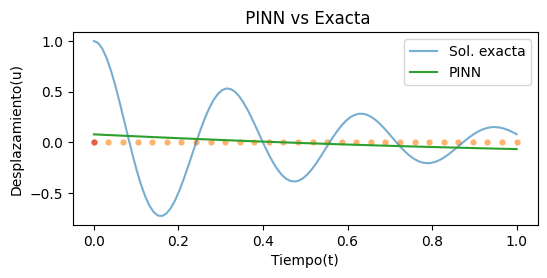

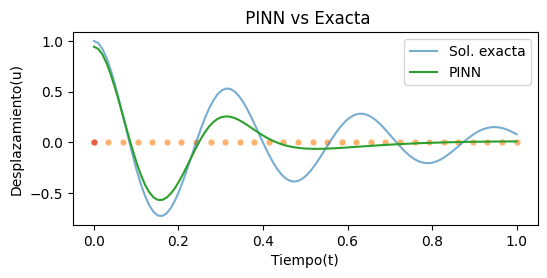

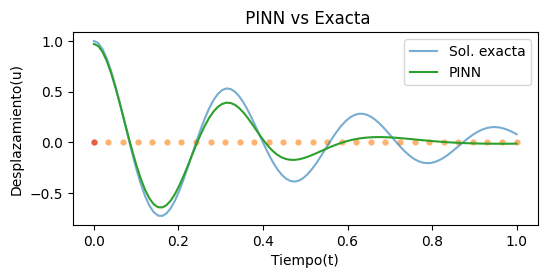

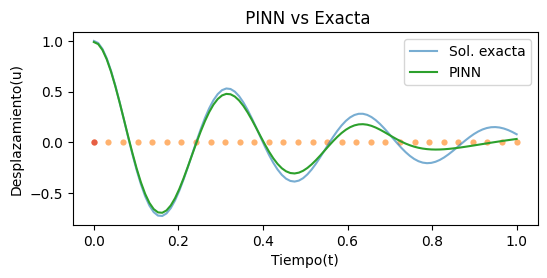

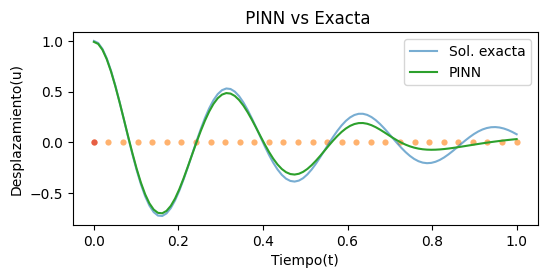

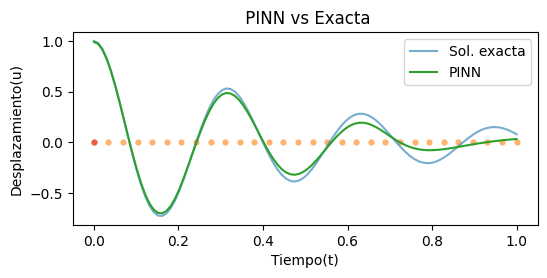

In [ ]:
class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
torch.manual_seed(123)

# define a neural network to train
# TODO: write code here
pinn = FCN(1,1,32,3)

# define boundary points, for the boundary loss
# TODO: write code here
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
# TODO: write code here
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True) #Tphisisss

# train the PINN
#d, w0 = 0.5, 10
d=2.0
w0=20.0
mu, k = 2*d, w0**2
t_test = torch.linspace(0, 1,100).reshape(-1,1)
#t_test = torch.linspace(0,10,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)
for i in range(5001):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 1e-4

    # compute boundary loss
    # TODO: write code here
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2

    # compute physics loss
    # TODO: write code here
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()

    # plot the result as training progresses
    if i % 1000 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:orange", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Sol. exacta", color="tab:blue", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN", color="tab:green")
        #plt.title(f"Training step {i}")
        plt.xlabel('Tiempo(t)')
        plt.ylabel('Desplazamiento(u)')
        plt.title(' PINN vs Exacta')
        plt.legend()
        plt.show()


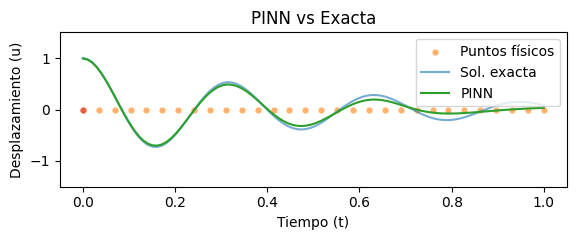

In [ ]:
# Evaluar el modelo entrenado sobre el conjunto de prueba
u = pinn(t_test).detach()

# Crear figura
plt.figure(figsize=(6, 2.5))

# Graficar puntos de la física
plt.scatter(
    t_physics.detach()[:, 0],
    torch.zeros_like(t_physics)[:, 0],
    s=20, lw=0, color="tab:orange", alpha=0.6,
    label="Puntos físicos"
)

# Graficar puntos de frontera
plt.scatter(
    t_boundary.detach()[:, 0],
    torch.zeros_like(t_boundary)[:, 0],
    s=20, lw=0, color="tab:red", alpha=0.6,
    #label="Cond. frontera"
)

# Graficar solución exacta
plt.plot(
    t_test[:, 0], u_exact[:, 0],
    label="Sol. exacta", color="tab:blue", alpha=0.6
)

# Graficar predicción de la PINN
plt.plot(
    t_test[:, 0], u[:, 0],
    label="PINN", color="tab:green"
)

# Etiquetas y título
plt.xlabel('Tiempo (t)')
plt.ylabel('Desplazamiento (u)')
plt.ylim(-1.5, 1.5)
plt.legend(loc='upper right')
plt.title('PINN vs Exacta')
plt.legend()
plt.tight_layout()
# Guardar como PDF
plt.savefig("pinn_vs_exacta.pdf", format="pdf")
plt.show()

